In [48]:
import pandas as pd
import numpy as np
import os
import requests
import matplotlib.pyplot as plt

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers
import missingno as msno

# Data import 

In [12]:
def download_file(url, save_folder):
    '''If the file isn't already in the save folder, download it.'''
    local_filename = url.split('/')[-1]  #Get the name of the file being downloaded

    # if the file exists, don't download it again
    if os.path.isfile(os.path.join(save_folder, local_filename)): return os.path.join(save_folder, local_filename)

    # NOTE the stream=True parameter
    r = requests.get(url, stream=True)
    with open(os.path.join(save_folder, local_filename), 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)
    return os.path.join(save_folder, local_filename)  #Returns the path pointing to the local file


In [13]:
cleveland = download_file(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", os.getcwd())
switzerland = download_file(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data",
        os.getcwd())
va = download_file("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data",
                       os.getcwd())
hungarian = download_file(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/reprocessed.hungarian.data", os.getcwd())


In [14]:
# Step 2: load the data into pandas DataFrames and then merge the four files into a single dataframe
cleveland_df = pd.read_csv(cleveland, header=None, na_values =["?", -9.0])
switzerland_df = pd.read_csv(switzerland, header=None, na_values =["?", -9.0])
va_df = pd.read_csv(va, header=None, na_values =["?", -9.0])
hungarian_df = pd.read_csv(hungarian, sep=" ", header=None, na_values =["?", -9.0])

# add headers to the data frames
headers = {0 : "Age",
           1 : "Sex", # 1 = male; 0 = female
           2 : "ChestPainType",  # chest pain type, 
                      # Value 1: typical angina, 
                      # Value 2: atypical angina, 
                      # Value 3: non-anginal pain
                      # Value 4: asymptomatic
           3 : "RestingBP", # resting blood pressure 
                           #(in mm Hg on admission to the hospital)
           4 : "Cholesterol", # serum cholestoral in mg/dl
           5 : "FastingBS", # fasting blood sugar > 120 mg/dl 
                     # (1 = true; 0 = false)
           6 : "RestingECG",#  resting electrocardiographic results
                         # Value 0: normal
                         # Value 1: having ST-T wave abnormality 
                         # (T wave inversions and/or ST elevation or depression of > 0.05 mV)
                         # Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
           7 : "MaxHR", #maximum heart rate achieved
           8 : "ExerciseAngina",# exercise induced angina (1 = yes; 0 = no)
           9 : "Oldpeak", # ST depression induced by exercise relative to rest
           10 : "ST_Slope", # the slope of the peak exercise ST segment
                         # Value 1: upsloping
                         # Value 2: flat
                         # Value 3: downsloping
           11 : "ca", # number of major vessels (0-3) colored by flourosopy    
           12 : "thal", # Value 3: normal
                        # Value 6: fixed defect
                        # Value 7: reversable defect
           13 : "HeartDisease" # diagnosis of heart disease (angiographic disease status)
                            # Value 0 = < 50% diameter narrowing,
                            # Value 1 = > 50% diameter narrowing 
                            # It takes 5 levels based on angiographic disease status.
                            # 0-Healthy, 1-diagnosed with stage 1, 2-diagnosed with stage 2, 
                            # 3-diagnosed with stage 3, 4-diagnosed with stage 4.
          }
cleveland_df = cleveland_df.rename(columns=headers)
switzerland_df = switzerland_df.rename(columns=headers)
va_df = va_df.rename(columns=headers)
hungarian_df = hungarian_df.rename(columns=headers)
cleveland_df['Location'] = 'Cleveland'
switzerland_df['Location'] = 'Switzerland'
va_df['Location']='VA'
hungarian_df['Location']='Hungarian'
hungarian_df = hungarian_df[:-1]


# # make a binary target variable
# cleveland_df['target'] = cleveland_df['HeartDisease'].copy()
# cleveland_df.target = cleveland_df.target.replace([1, 2, 3, 4], 1)
# switzerland_df['target'] = switzerland_df['HeartDisease'].copy()
# switzerland_df.target = switzerland_df.target.replace([1, 2, 3, 4], 1)
# va_df['target'] = va_df['HeartDisease'].copy()
# va_df.target = va_df.target.replace([1, 2, 3, 4], 1)
# hungarian_df['target'] = hungarian_df['HeartDisease'].copy()
# hungarian_df.target = hungarian_df.target.replace([1, 2, 3, 4], 1)


## EDA

<AxesSubplot:>

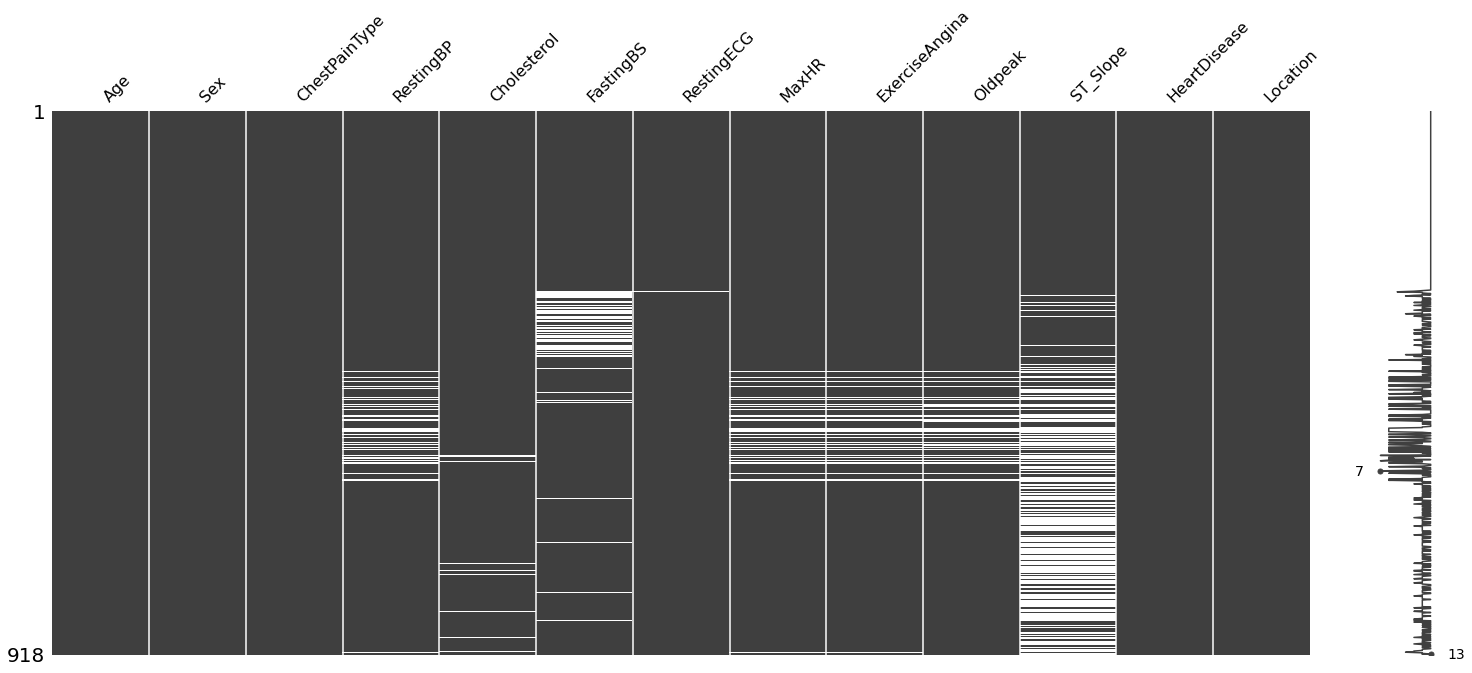

In [17]:
df = pd.concat([cleveland_df, switzerland_df, va_df, hungarian_df])
df.HeartDisease = df.HeartDisease.replace([1, 2, 3, 4], 1)
df = df.drop(columns=['thal', 'ca'])
df = df.drop_duplicates()
msno.matrix(df)

In [18]:
perc = 35.0 
min_count =  int(((100-perc)/100)*df.shape[1] + 1)
df = df.dropna( axis=0, thresh=min_count)

In [30]:
# # FILL MISSING VALUES WITH MEDIAN
df.ST_Slope = df.ST_Slope.fillna(df.ST_Slope.median())
df.RestingBP = df.RestingBP.fillna(df.RestingBP.median())
df.FastingBS = df.FastingBS.fillna(df.FastingBS.median())
df.RestingECG = df.RestingECG.fillna(df.RestingECG.median())
df.Cholesterol = df.Cholesterol.fillna(df.Cholesterol.median())
df.MaxHR = df.MaxHR.fillna(df.MaxHR.median())
df.ExerciseAngina = df.ExerciseAngina.fillna(df.ExerciseAngina.median())
df.Oldpeak = df.Oldpeak.fillna(df.Oldpeak.median())

# # DROP ROW WHERE RESTING BP = 0
df = df[df.RestingBP != 0]

In [31]:
df.Cholesterol = df.Cholesterol.replace(0, df.Cholesterol.median())

In [32]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

In [33]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('HeartDisease')
test_labels = test_features.pop('HeartDisease')

In [34]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Age,53.155072,9.483957
Sex,0.786957,0.409755
ChestPainType,3.259420,0.944439
RestingBP,132.371014,18.560262
Cholesterol,241.114493,48.482247
FastingBS,0.136232,0.343283
RestingECG,0.584058,0.806023
MaxHR,137.842029,25.608354
ExerciseAngina,0.395652,0.489345
Oldpeak,0.880870,1.066325


In [24]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [36]:
train_features.pop('Location')
train_features

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
55,54.0,1.0,4.0,124.0,266.0,0.0,2.0,109.0,1.0,2.2,2.0
13,42.0,1.0,4.0,145.0,224.0,0.0,0.0,99.0,1.0,0.0,2.0
252,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0
262,60.0,0.0,1.0,150.0,240.0,0.0,0.0,171.0,0.0,0.9,1.0
31,60.0,1.0,4.0,117.0,230.0,1.0,0.0,160.0,1.0,1.4,1.0
...,...,...,...,...,...,...,...,...,...,...,...
117,35.0,0.0,4.0,138.0,183.0,0.0,0.0,182.0,0.0,1.4,1.0
48,59.0,1.0,3.0,130.0,224.0,0.0,0.0,128.0,1.0,2.0,3.0
25,50.0,0.0,3.0,120.0,219.0,0.0,0.0,158.0,0.0,1.6,2.0
110,61.0,0.0,4.0,145.0,307.0,0.0,2.0,146.0,1.0,1.0,2.0


In [37]:
normalizer.adapt(np.array(train_features))

In [38]:
print(normalizer.mean.numpy())

[[ 53.155   0.787   3.259 132.371 241.115   0.136   0.584 137.842   0.396
    0.881   1.846]]


In [40]:
Age = np.array(train_features['Age'])

Age_normalizer = layers.Normalization(input_shape=[1,], axis=None)
Age_normalizer.adapt(Age)

In [41]:
Age_model = tf.keras.Sequential([
    Age_normalizer,
    layers.Dense(units=1)
])

Age_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [42]:
Age_model.predict(Age[:10])

array([[-0.136],
       [ 1.796],
       [-1.746],
       [-1.102],
       [-1.102],
       [-0.619],
       [-1.263],
       [ 2.44 ],
       [ 2.279],
       [-0.941]], dtype=float32)

In [43]:
Age_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [44]:
history = Age_model.fit(
    train_features['Age'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

In [45]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.427280,0.402311,95
96,0.420347,0.405583,96
97,0.428929,0.406994,97
98,0.423702,0.398034,98
99,0.422884,0.403691,99


In [57]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [HeartDisease]')
  plt.legend()
  plt.grid(True)

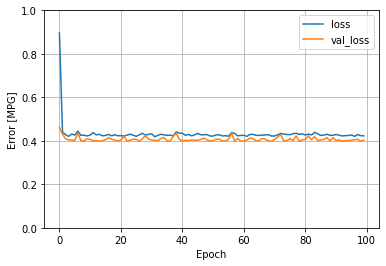

In [53]:
plot_loss(history)

In [58]:
test_results = {}

test_results['Age_model'] = Age_model.evaluate(
    test_features['Age'],
    test_labels, verbose=0)

In [69]:
x = tf.linspace(20, 80, 400)
y = Age_model.predict(x)

In [70]:
def plot_Age(x, y):
  plt.scatter(train_features['Age'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Age')
  plt.ylabel('HeartDisease')
  plt.legend()

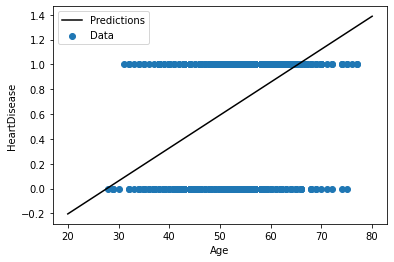

In [71]:
plot_Age(x, y)

In [72]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [73]:
linear_model.predict(train_features[:10])

array([[-1.283],
       [-1.087],
       [-0.323],
       [ 0.477],
       [-0.212],
       [-0.488],
       [ 0.236],
       [-1.126],
       [-0.685],
       [-1.396]], dtype=float32)

In [74]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


In [75]:
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)



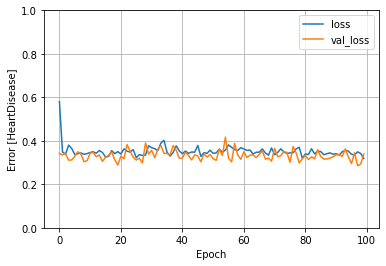

In [76]:
plot_loss(history)

In [82]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [93]:
test_results

{'Age_model': 0.4016423225402832, 'linear_model': 0.16790884733200073}

In [94]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T


,Mean absolute error [MPG]
Age_model,0.401642
linear_model,0.167909
